In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, AutoTokenizer, AutoModel
from transformers import Trainer, TrainingArguments
from tqdm import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor

from sklearn.linear_model import LogisticRegression

2024-04-06 06:11:41.653040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 06:11:41.653204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 06:11:41.796918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/train.csv')
train_data.head(2)
train_text = train_data.Text
train_labels = train_data['Class']

In [3]:
train_labels = train_data['Class'].apply(lambda x: 1 if x == 'M' else 0)

In [4]:
train_text = train_text[:50000]
train_labels = train_labels[:50000]

In [5]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, token_size=64)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

In [6]:
sentences = list(train_text)

In [7]:
batch_size = 32

In [8]:
max_seq_length = 64
batches_processed = 0
amount_of_batches = len(sentences) // batch_size

In [9]:
def process_batch(batch_sentences):
    inputs = tokenizer(batch_sentences, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors="pt")
    global batches_processed
    with torch.no_grad():
        outputs = model(**inputs)
    batches_processed += 1
    print(f"Processed {batches_processed} out of {amount_of_batches} batches", flush=True)
    return outputs.last_hidden_state

# Function to process batches and obtain embeddings
def process_batches(sentences, labels):
    embeddings_list = []
    label_list = []
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on available CPU cores
        for i in range(0, len(sentences), batch_size):
            batch_sentences = sentences[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            # Submit batch processing to ThreadPoolExecutor
            future = executor.submit(process_batch, batch_sentences)
            # Increment the counter for batches processed
            # Append the Future object to a list
            embeddings_list.append(future)
            label_list.extend(batch_labels)
    # Extract results from Future objects
    embeddings = torch.cat([future.result() for future in embeddings_list], dim=0)
    labels_tensor = torch.tensor(label_list)
    return embeddings, labels_tensor

In [10]:
# Obtain embeddings for the entire dataset
embeddings, labels = process_batches(sentences, train_labels)

# Convert PyTorch tensor to NumPy array
embeddings_numpy = embeddings.numpy()

# Print the shape of the embeddings
print("Embeddings shape:", embeddings_numpy.shape)

Processed 1 out of 1562 batches
Processed 2 out of 1562 batches
Processed 3 out of 1562 batches
Processed 4 out of 1562 batches
Processed 5 out of 1562 batches
Processed 6 out of 1562 batches
Processed 7 out of 1562 batches
Processed 8 out of 1562 batches
Processed 9 out of 1562 batches
Processed 10 out of 1562 batches
Processed 11 out of 1562 batches
Processed 12 out of 1562 batches
Processed 13 out of 1562 batches
Processed 14 out of 1562 batches
Processed 15 out of 1562 batches
Processed 16 out of 1562 batches
Processed 17 out of 1562 batches
Processed 18 out of 1562 batches
Processed 19 out of 1562 batches
Processed 20 out of 1562 batches
Processed 21 out of 1562 batches
Processed 22 out of 1562 batches
Processed 23 out of 1562 batches
Processed 24 out of 1562 batches
Processed 25 out of 1562 batches
Processed 26 out of 1562 batches
Processed 27 out of 1562 batches
Processed 28 out of 1562 batches
Processed 29 out of 1562 batches
Processed 30 out of 1562 batches
Processed 31 out of

In [13]:
labels_numpy = labels.numpy()
save_embeddings(embeddings_numpy, labels_numpy, 'embeddings_train_data_ruatd.pkl')

In [ ]:
with open('train_embeddings.txt', 'w') as f:
    f.writelines(f"\{{item}:\n" for item in for i in embeddings_numpy)

In [2]:
import torch
import pickle

# Save embeddings and labels to a file
def save_embeddings(embeddings, labels, filename):
    data = {
        'embeddings': embeddings,
        'labels': labels
    }
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Load embeddings and labels from a file
def load_embeddings(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data['embeddings'], data['labels']

In [11]:
test_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/val.csv')
test_data.head(2)
test_text = test_data.Text
test_labels = test_data['Class'].apply(lambda x: 1 if x == 'M' else 0)
# test_labels = test_data['Class']

In [12]:
test_sentences = list(test_text)
test_sentences[0]

'В связи с этим в подпрограмму включены следующие мероприятия, в том числе определенные Федеральной целевой программой развития образования:'

In [13]:
max_seq_length = 64
batches_processed = 0
amount_of_batches = len(test_sentences) // batch_size

In [14]:
# Obtain embeddings for the entire dataset
test_embeddings, labels = process_batches(test_sentences, test_labels)

# Convert PyTorch tensor to NumPy array
embeddings_numpy = test_embeddings.numpy()

# Print the shape of the embeddings
print("Embeddings shape:", embeddings_numpy.shape)

Processed 1 out of 672 batches
Processed 2 out of 672 batches
Processed 3 out of 672 batches
Processed 4 out of 672 batches
Processed 5 out of 672 batches
Processed 6 out of 672 batches
Processed 7 out of 672 batches
Processed 8 out of 672 batches
Processed 9 out of 672 batches
Processed 10 out of 672 batches
Processed 11 out of 672 batches
Processed 12 out of 672 batches
Processed 13 out of 672 batches
Processed 14 out of 672 batches
Processed 15 out of 672 batches
Processed 16 out of 672 batches
Processed 17 out of 672 batches
Processed 18 out of 672 batches
Processed 19 out of 672 batches
Processed 20 out of 672 batches
Processed 21 out of 672 batches
Processed 22 out of 672 batches
Processed 23 out of 672 batches
Processed 24 out of 672 batches
Processed 25 out of 672 batches
Processed 26 out of 672 batches
Processed 27 out of 672 batches
Processed 28 out of 672 batches
Processed 29 out of 672 batches
Processed 30 out of 672 batches
Processed 31 out of 672 batches
Processed 32 out 

In [15]:
labels_numpy = labels.numpy()
save_embeddings(embeddings_numpy, labels_numpy, 'embeddings_test_data_ruatd.pkl')

In [3]:
# # Load embeddings and labels from the file
train_embeddings_loaded, train_labels_loaded = load_embeddings('/kaggle/input/embeddings-ruatd-bin-task/embeddings_train_data_ruatd.pkl')

# # Use the loaded embeddings and labels as needed
print("Loaded embeddings shape:", train_embeddings_loaded.shape)
print("Loaded labels shape:", train_labels_loaded.shape)

Loaded embeddings shape: (50000, 64, 768)
Loaded labels shape: (50000,)


In [3]:
# # Load embeddings and labels from the file
test_embeddings_loaded, test_labels_loaded = load_embeddings('/kaggle/input/embeddings-ruatd-bin-task/embeddings_test_data_ruatd.pkl')

# # Use the loaded embeddings and labels as needed
print("Loaded embeddings shape:", test_embeddings_loaded.shape)
print("Loaded labels shape:", test_labels_loaded.shape)

NameError: name 'embeddings_loaded' is not defined

In [4]:
train_embeddings_flat = train_embeddings_loaded.reshape(train_embeddings_loaded.shape[0], -1)

In [4]:
test_embeddings_flat = test_embeddings_loaded.reshape(test_embeddings_loaded.shape[0], -1)

In [ ]:
test_embeddings_flat[0]

In [6]:
classifier = LogisticRegression()
classifier.fit(train_embeddings_flat, train_labels_loaded)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(classifier, file)

In [5]:
with open('/kaggle/input/embeddings-ruatd-bin-task/logistic_regression_model.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [6]:
from sklearn.metrics import accuracy_score

test_predictions = classifier.predict(test_embeddings_flat)
accuracy = accuracy_score(test_labels_loaded, test_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.667751383013342


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

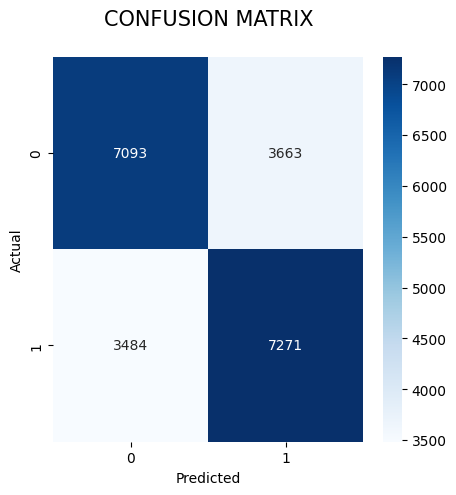

In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = metrics.confusion_matrix(test_labels_loaded, test_predictions)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)